# Load observed link flows

In [118]:
using JSON
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
#pyimport_conda("Compute_Jacobian", "Anaconda")
@pyimport parameters_julia
@pyimport Compute_Jacobian
@pyimport GLS_julia

In [119]:
numNodes = Compute_Jacobian.numNodes;
numLinks = Compute_Jacobian.numLinks;
numODpairs = Compute_Jacobian.numODpairs;
numZones = Compute_Jacobian.numZones
od_pairs = Compute_Jacobian.od_pairs;
link_list_js = Compute_Jacobian.link_list_js;
link_length_list = Compute_Jacobian.link_length_list;

In [120]:
include("Julia_files/initia_data.jl");
include("prepare_data.jl");
include("extract_data.jl");

In [121]:
flow_observ = GLS_julia.x_;
month_w  = parameters_julia.month_w

"May"

# Load pre-calculated socially-optimal link flows

In [122]:
instance = "MD"

"MD"

In [123]:
tapSocialFlowVecDictAprPM = readstring(out_dir * "tapSocialFlowVecDict_" * month_w * "_" * instance * ".json");
tapSocialFlowVecDictAprPM = JSON.parse(tapSocialFlowVecDictAprPM);

In [124]:
#tapSocialFlowVecDictAprWeekend = readstring(out_dir * "tapSocialFlowVecDict_" * month_w * "_" * instance ".json");
#tapSocialFlowVecDictAprWeekend = JSON.parse(tapSocialFlowVecDictAprWeekend);

In [125]:
tapSocialFlowVecDictApr = Dict{}()

for key in keys(tapSocialFlowVecDictAprPM)
    tapSocialFlowVecDictApr[key] = tapSocialFlowVecDictAprPM[key]
end

#for key in keys(tapSocialFlowVecDictAprWeekend)
#    tapSocialFlowVecDictApr[key] = tapSocialFlowVecDictAprWeekend[key]
#end

In [126]:
tapSocialFlowVecDictApr["1"];

In [127]:
flow_observ[:, 1];

# Meta analysis for zone costs

In [128]:
link_label_dict;

In [129]:
link_label_dict_converted = Dict()

for key in keys(link_label_dict)
    link_label_dict_converted[parse(Int, key) + 1] = [parse(Int, split(link_label_dict[key], ',')[1]), 
        parse(Int, split(link_label_dict[key], ',')[2])]
end

In [130]:
link_label_dict_converted;

In [131]:
od_nodesList_dict = Dict()
od_nodesList_dict = GLS_julia.od_nodesList_dict;

In [132]:
od_nodesList_dict_converted = Dict()

for key in keys(od_nodesList_dict)
    od_nodesList_dict_converted[key + 1] = od_nodesList_dict[key]
end

In [133]:
od_nodesList_dict_converted

Dict{Any,Any} with 8 entries:
  7 => [6]
  4 => [3]
  9 => [8]
  2 => [1]
  3 => [2]
  8 => [7]
  5 => [4]
  6 => [5]

In [134]:
zone_links_dict = Dict()

for key in keys(od_nodesList_dict_converted)
    link_list = []
    for link_idx in keys(link_label_dict_converted)
        if link_label_dict_converted[link_idx][1] in od_nodesList_dict_converted[key] ||
            link_label_dict_converted[link_idx][2] in od_nodesList_dict_converted[key]
            push!(link_list, link_idx)
        end
    end
    zone_links_dict[key] = link_list
end

In [135]:
link_label_dict_converted

Dict{Any,Any} with 24 entries:
  1  => [1, 2]
  2  => [1, 3]
  16 => [5, 7]
  11 => [4, 2]
  21 => [7, 5]
  7  => [3, 2]
  9  => [3, 6]
  10 => [4, 8]
  19 => [6, 7]
  17 => [6, 3]
  8  => [3, 5]
  22 => [7, 6]
  6  => [3, 1]
  24 => [8, 7]
  4  => [2, 3]
  3  => [2, 1]
  5  => [2, 4]
  20 => [7, 8]
  23 => [8, 4]
  13 => [5, 3]
  14 => [5, 4]
  15 => [5, 6]
  12 => [4, 5]
  18 => [6, 5]

In [136]:
zone_links_dict

Dict{Any,Any} with 8 entries:
  7 => Any[9, 19, 17, 22, 15, 18]
  4 => Any[2, 7, 9, 17, 8, 6, 4, 13]
  9 => Any[10, 24, 20, 23]
  2 => Any[1, 2, 6, 3]
  3 => Any[1, 11, 7, 4, 3, 5]
  8 => Any[16, 21, 19, 22, 24, 20]
  5 => Any[11, 10, 5, 23, 14, 12]
  6 => Any[16, 21, 8, 13, 14, 15, 12, 18]

## Zone cost definition:
Let $\mathcal{A}_i$ denote the link set related to zone $i$ (each link in $\mathcal{A}_i$ has at least one node contained in zone $i$). Then the total users' cost for zone $i$ is
$${C_i} = \sum\limits_{a \in {\mathcal{A}_i}} {{{x_a}} {{t_a}\left( x_a \right)} } $$

In [137]:
function usersObj(fcoeffs, free_flow_time, capacity, linkFlowVec, linkIndices)
    objVal = sum([sum([free_flow_time[a] * fcoeffs[j] * linkFlowVec[a]^j / capacity[a]^(j-1) 
            for j = 1:length(fcoeffs)]) for a in linkIndices])
    return objVal
end

usersObj (generic function with 1 method)

## Scenario 1: weekdays of April 2012, PM period

In [138]:
key_ = "(5, 1.5, 1000.0, 1)"

coeffs_dict_Apr_PM_ = readstring(out_dir * "coeffs_dict_" * month_w * "_" * instance * ".json");
coeffs_dict_Apr_PM_ = JSON.parse(coeffs_dict_Apr_PM_);
fcoeffs_Apr_PM = coeffs_dict_Apr_PM_[key_];

In [139]:
free_flow_time_Apr_PM = ta_data_Apr_PM.free_flow_time;
capacity_Apr_PM = ta_data_Apr_PM.capacity;

In [140]:
# calculate costs for zones, weekdays of April 2012, PM period

zone_cost_dict_Apr_PM_user = Dict();
zone_cost_dict_Apr_PM_social = Dict();

week_day_Apr_list = parameters_julia.week_day_list

for day = 1:length(week_day_Apr_list)
    for zone = 2:length(zone_links_dict)+1
        # user-centric policy
        zone_cost_dict_Apr_PM_user[(day, zone)] = usersObj(fcoeffs_Apr_PM, free_flow_time_Apr_PM, 
        capacity_Apr_PM, flow_observ[:, day], zone_links_dict[zone])

        # system-centric policy
        zone_cost_dict_Apr_PM_social[(day, zone)] = usersObj(fcoeffs_Apr_PM, free_flow_time_Apr_PM, 
        capacity_Apr_PM, tapSocialFlowVecDictApr["$(day)"], zone_links_dict[zone])
    end
end

In [141]:
zone_links_dict

Dict{Any,Any} with 8 entries:
  7 => Any[9, 19, 17, 22, 15, 18]
  4 => Any[2, 7, 9, 17, 8, 6, 4, 13]
  9 => Any[10, 24, 20, 23]
  2 => Any[1, 2, 6, 3]
  3 => Any[1, 11, 7, 4, 3, 5]
  8 => Any[16, 21, 19, 22, 24, 20]
  5 => Any[11, 10, 5, 23, 14, 12]
  6 => Any[16, 21, 8, 13, 14, 15, 12, 18]

In [142]:
day = 2

for zone = 2:length(zone_links_dict)
    println([zone_cost_dict_Apr_PM_user[(day, zone)], zone_cost_dict_Apr_PM_social[(day, zone)]])
end

## Visualization of zone costs (user-centric vs. system-centric)

### Three observations can be made: 

#### (1) Overall, most zone costs would be reduced when switching from user-centric policy to system-centric policy.

#### (2) In general, the zone costs for weekends are less than their counterparts for weekdays; this is consistent with intuition.

#### (3) The decrease seems more constant for all zones in weekends than in weekdays, meaning it is easier to optimize the network for weekends than for weekdays; this is again consistent with intuition. 

In [143]:
using PyPlot

## Plots for weekdays

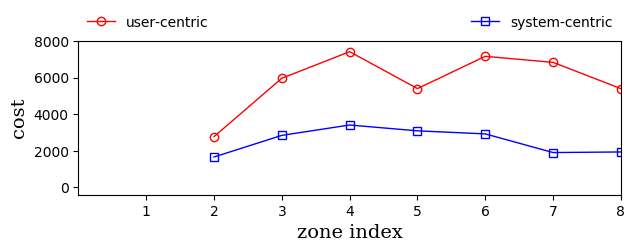

In [144]:
using PyPlot;
plt = PyPlot;

dire = out_dir

# for day in week_day_Apr_list 
for day in [18]

    fig = figure(figsize=(7,2))

    zone = 2:length(zone_links_dict)

    zone_cost_vec_Apr_PM_user = [zone_cost_dict_Apr_PM_user[(day, zone_idx)] for zone_idx in zone]
    zone_cost_vec_Apr_PM_social = [zone_cost_dict_Apr_PM_social[(day, zone_idx)] for zone_idx in zone]

    plot(zone, zone_cost_vec_Apr_PM_user, "o-r", linewidth=1, label="user-centric",
    markerfacecolor="None", markeredgecolor="r", markeredgewidth=1)
    
    plot(zone, zone_cost_vec_Apr_PM_social, "s-b", linewidth=1, label="system-centric",
    markerfacecolor="None", markeredgecolor="b", markeredgewidth=1)

    # legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
#     legend(loc=0, fancybox="true", numpoints=1) 
    plt.legend(frameon=false, ncol=2, bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", 
    borderaxespad=0.2, numpoints=1)
    
#     grid("on")

    xlim(0, 8)
    xticks(1:1:8)
    ylim(-400, maximum([maximum(zone_cost_vec_Apr_PM_user), maximum(zone_cost_vec_Apr_PM_social)])+600)

    font1 = Dict("family"=>"serif", "color"=>"k", "weight"=>"normal", "size"=>14)

    xlabel("zone index", fontdict=font1)
    ylabel("cost", fontdict=font1)

#     savefig("./results/Zone_costs_Apr_$(day)_journal.pdf")
    
    savefig(dire * "Zone_costs_" * month_w *"_$(day)" * files_ID * ".pdf", dpi=300, bbox_inches="tight")
    
end

## Plots for weekends

# Meta analysis for link flows

## maximum and minimum link flows

In [145]:
max_link_flow_social_dict = Dict()
min_link_flow_social_dict = Dict()

for day = 1:length(week_day_Apr_list)
    # maximum link flow (social)
    max_link_flow_social_dict[day] = findmax(tapSocialFlowVecDictApr["$(day)"])

    # minimum link flow (social)
    min_link_flow_social_dict[day] = findmin(tapSocialFlowVecDictApr["$(day)"])
end

[1529.03, 1661.49]
[1802.93, 2843.21]
[4797.37, 3409.82]
[1568.84, 3091.06]
[4495.76, 2924.5]
[5508.23, 1904.64]
[4275.17, 1936.75]


In [146]:
max_link_flow_user_dict = Dict()
min_link_flow_user_dict = Dict()

for day = 1:length(week_day_Apr_list)
    # maximum link flow (user)
    max_link_flow_user_dict[day] = findmax(flow_observ[:, day])

    # minimum link flow (user)
    min_link_flow_user_dict[day] = findmin(flow_observ[:, day])
end

In [147]:
max_link_flow_social_dict

Dict{Any,Any} with 23 entries:
  18 => (2680.17, 8)
  2  => (2680.17, 8)
  16 => (2680.17, 8)
  11 => (2680.17, 8)
  21 => (2680.17, 8)
  7  => (2680.17, 8)
  9  => (2680.17, 8)
  10 => (2680.17, 8)
  19 => (2680.17, 8)
  17 => (2680.17, 8)
  8  => (2680.17, 8)
  22 => (2680.17, 8)
  6  => (2680.17, 8)
  4  => (2680.17, 8)
  3  => (2680.17, 8)
  5  => (2680.17, 8)
  20 => (2680.17, 8)
  23 => (2680.17, 8)
  13 => (2680.17, 8)
  14 => (2680.17, 8)
  15 => (2680.17, 8)
  12 => (2680.17, 8)
  1  => (2680.17, 8)

In [148]:
max_link_flow_user_dict

Dict{Any,Any} with 23 entries:
  18 => (7119.2, 21)
  2  => (5868.24, 9)
  16 => (7193.22, 8)
  11 => (7348.73, 8)
  21 => (6871.74, 21)
  7  => (7095.67, 8)
  9  => (7040.25, 21)
  10 => (6816.76, 9)
  19 => (5859.1, 19)
  17 => (7410.12, 8)
  8  => (6430.83, 21)
  22 => (6948.93, 21)
  6  => (7481.7, 8)
  4  => (7088.49, 9)
  3  => (6901.09, 9)
  5  => (6474.22, 9)
  20 => (1795.13, 2)
  23 => (6779.93, 9)
  13 => (6941.28, 8)
  14 => (6934.13, 9)
  15 => (7611.56, 8)
  12 => (6649.29, 8)
  1  => (6936.39, 9)

In [149]:
fig = figure(figsize=(7,2))

day = 1:length(max_link_flow_social_dict)

max_link_flow_social_vec = [max_link_flow_social_dict[idx][1] for idx in day]
min_link_flow_social_vec = [min_link_flow_social_dict[idx][1] for idx in day]

max_link_flow_user_vec = [max_link_flow_user_dict[idx][1] for idx in day]
min_link_flow_user_vec = [min_link_flow_user_dict[idx][1] for idx in day]

plot(day, max_link_flow_social_vec, "s-b", linewidth=1, label="max system-centric", 
markerfacecolor="None", markeredgecolor="b", markeredgewidth=1)

plot(day, max_link_flow_user_vec, "o-r", linewidth=1, label="max user-centric", 
markerfacecolor="None", markeredgecolor="r", markeredgewidth=1)

plot(day, min_link_flow_social_vec, "v-m", linewidth=1, label="min system-centric",
markerfacecolor="None", markeredgecolor="m", markeredgewidth=1)

plot(day, min_link_flow_user_vec, "*-g", linewidth=1, label="min user-centric",
markerfacecolor="None", markeredgecolor="g", markeredgewidth=1)

# legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, fancybox="true", ncol=2, mode="expand", 
borderaxespad=0.2, numpoints=1, frameon=false)  

# grid("on")

xlim(0, 24)
xticks(1:2:24)
ylim(-300, maximum([maximum(max_link_flow_social_vec), maximum(max_link_flow_user_vec)])+500)

font1 = Dict("family"=>"serif", "color"=>"k", "weight"=>"normal", "size"=>14)

xlabel("day of " * month_w * " " * string(year), fontdict=font1)
ylabel("link flow", fontdict=font1)

# savefig("./results/max_min_link_flow_Apr_journal.pdf")

savefig(dire * "max_min_link_flow_"* month * "_" * files_ID * ".pdf", dpi=300, bbox_inches="tight")

LoadError: [91mUndefVarError: year not defined[39m

In [150]:
fig = figure(figsize=(7,2))

day = 1:length(max_link_flow_social_dict)

max_link_flow_social_vec = [max_link_flow_social_dict[idx][2] for idx in day]
min_link_flow_social_vec = [min_link_flow_social_dict[idx][2] for idx in day]

max_link_flow_user_vec = [max_link_flow_user_dict[idx][2] for idx in day]
min_link_flow_user_vec = [min_link_flow_user_dict[idx][2] for idx in day]

plot(day, max_link_flow_social_vec, "s-b", linewidth=1, label="max system-centric", 
markerfacecolor="None", markeredgecolor="b", markeredgewidth=1)

plot(day, max_link_flow_user_vec, "o-r", linewidth=1, label="max user-centric", 
markerfacecolor="None", markeredgecolor="r", markeredgewidth=1)

plot(day, min_link_flow_social_vec, "v-m", linewidth=1, label="min system-centric",
markerfacecolor="None", markeredgecolor="m", markeredgewidth=1)

plot(day, min_link_flow_user_vec, "*-g", linewidth=1, label="min user-centric",
markerfacecolor="None", markeredgecolor="g", markeredgewidth=1)

# legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
# legend(loc=0, fancybox="true", ncol=2, mode="expand", borderaxespad=0.2, numpoints=1, frameon=false)  

# grid("on")

xlim(0, 24)
xticks(1:2:24)
ylim(-2, maximum([maximum(max_link_flow_social_vec), maximum(max_link_flow_user_vec)]) + 15)
# yticks(4:164)

font1 = Dict("family"=>"serif", "color"=>"k", "weight"=>"normal", "size"=>14)

xlabel("day of " * month_w * " " * string(year), fontdict=font1)
ylabel("link index", fontdict=font1)

# savefig("./results/max_min_link_index_Apr_journal.pdf")

savefig(dire * "max_min_link_index_" * month * "_" * files_ID * ".pdf", dpi=300, bbox_inches="tight")

LoadError: [91mUndefVarError: year not defined[39m

# Meta analysis for link congestion

Based on Greenshield's model, we could define the $\textbf{Congestion Metric}$ for link $a$ as 
$${\text{CM}_a} = \left\{ \begin{gathered}
  1 - \frac{{{x_a}}}{{{m_a}}} = 1 - 4\left[ {\frac{{{v_a}}}{{v_a^0}} - {{\left( {\frac{{{v_a}}}{{v_a^0}}} \right)}^2}} \right],{\text{ if }}0 \leq {v_a} < \frac{{v_a^0}}{2}, \hfill \\
  0,{\text{ if }}{v_a} \geq \frac{{v_a^0}}{2}, \hfill \\ 
\end{gathered}  \right.$$
where $x_a$ and $m_a$ are the $\textbf{link flow}$ and $\textbf{flow capacity}$ respectively, and $v_a$ (resp., $v_a^0$) is the $\textbf{observed speed}$ (resp., $\textbf{free-flow speed}$) on link $a$. Note that in our analysis, we always have $\text{CM}_a \in [0,1]$; in particular, when ${v_a} \geq \frac{{v_a^0}}{2}$, we define $\text{CM}_a = 0$, meaning the congestion (if any) on link $a$ could be ignored. In our calculations, we take $v_a^0 = {s_a}\big/{t_a^0},$ where $s_a$ is the $\textbf{length}$ of link $a$ and $t_a^0$ is the $\textbf{free-flow travel time}$ of link $a$.

Note that this metric only works for the case where we have speed data. However, we actually do not have speed information for social flows. Thus, we need an alternative definition of link congestion metric. Here we want to use the ratio of $\textbf{travel time}$ to $\textbf{free-flow travel time}$:
$${\text{CM}_a} = \frac{{{t_a}\left( {{x_a}} \right)}}{{t_a^0}} = f\left( {\frac{{{x_a}}}{{{m_a}}}} \right),$$
where $f(\cdot)$ is the cost function that we have estimated. In this new definition, we always have $\text{CM}_a \geq 1$.

In [151]:
function congMetric(fcoeffs, capacity, linkFlow)
    CM = sum([fcoeffs[j] * linkFlow^(j-1) / capacity^(j-1) for j = 1:length(fcoeffs)])
    if CM < 1
        return 1.0
    end
    return CM
end

congMetric (generic function with 1 method)

## Scenario 1: weekdays of April 2012, PM period

In [152]:
# calculate congestion metric for links

link_congestion_metric_dict_Apr_PM_user = Dict();
link_congestion_metric_dict_Apr_PM_social = Dict();

week_day_Apr_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30];

for day = 1:length(week_day_Apr_list)
    for link = 1:numLinks
        # user-centric policy
        link_congestion_metric_dict_Apr_PM_user[(day, link)] = congMetric(fcoeffs_Apr_PM, 
        capacity_Apr_PM[link], flow_observ[:, day][link])

        # system-centric policy
        link_congestion_metric_dict_Apr_PM_social[(day, link)] = congMetric(fcoeffs_Apr_PM, 
        capacity_Apr_PM[link], tapSocialFlowVecDictApr["$(day)"][link])
    end
end

In [153]:
day = 4

for link = 1:numLinks
    println([link_congestion_metric_dict_Apr_PM_user[(day, link)], 
        link_congestion_metric_dict_Apr_PM_social[(day, link)]]);
end

In [154]:
link_congestion_metric_dict_Apr_PM_user_day = Dict();
for link = 1:numLinks
    link_congestion_metric_dict_Apr_PM_user_day[link] = link_congestion_metric_dict_Apr_PM_user[(day, link)];
end
sorted_vec_user = sort(collect(link_congestion_metric_dict_Apr_PM_user_day), by=x->x[2]);

[1.00126, 1.00095]
[1.00095, 1.0]
[1.00041, 1.00083]
[1.00047, 1.00117]
[1.00131, 1.00073]
[1.00048, 1.0011]
[1.00023, 1.00097]
[1.00312, 1.00145]
[1.00497, 1.00137]
[1.00053, 1.0012]
[1.00054, 1.00109]
[1.00124, 1.00135]
[1.00056, 1.00106]
[1.00233, 1.00066]
[1.00379, 1.00112]
[1.00052, 1.0009]
[1.00219, 1.00102]
[1.00439, 1.0008]
[1.00339, 1.00065]
[1.00047, 1.00108]
[1.0011, 1.00095]
[1.00329, 1.00069]
[1.0002, 1.00069]
[1.00086, 1.00151]


In [155]:
link_congestion_metric_dict_Apr_PM_social_day = Dict();
for link = 1:numLinks
    link_congestion_metric_dict_Apr_PM_social_day[link] = 
    link_congestion_metric_dict_Apr_PM_social[(day, link)];
end
sort(collect(link_congestion_metric_dict_Apr_PM_social_day), by=x->x[2]);

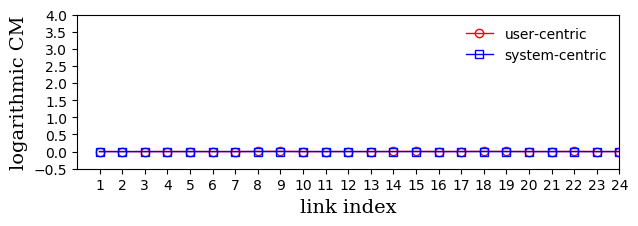

In [156]:
fig = figure(figsize=(7,2))

link = 1:numLinks

link_congestion_metric_vec_Apr_PM_user = [log2(link_congestion_metric_dict_Apr_PM_user[(day, link_idx)]) 
    for link_idx in link]
link_congestion_metric_vec_Apr_PM_social = [log2(link_congestion_metric_dict_Apr_PM_social[(day, link_idx)]) 
    for link_idx in link]

plot(link, link_congestion_metric_vec_Apr_PM_user, "o-r", linewidth=1, label="user-centric",
markerfacecolor="None", markeredgecolor="r", markeredgewidth=1)

plot(link, link_congestion_metric_vec_Apr_PM_social, "s-b", linewidth=1, label="system-centric",
markerfacecolor="None", markeredgecolor="b", markeredgewidth=1)

# legend(loc=0, fancybox="true", bbox_to_anchor=(0.1, 0)) 
legend(loc=0, fancybox="True", numpoints=1, frameon=false)   

# grid("on")

xlim(0, 24)
xticks(1:1:24)
ylim(0, maximum([maximum(link_congestion_metric_vec_Apr_PM_user), 
    maximum(link_congestion_metric_vec_Apr_PM_social)])+1)
yticks(-0.5:0.5:4)

font1 = Dict("family"=>"serif", "color"=>"k", "weight"=>"normal", "size"=>14)

xlabel("link index", fontdict=font1)
ylabel("logarithmic CM", fontdict=font1)

savefig(out_dir * "Link_congestion_metric_" * month_w * "_$(day)" * files_ID *  ".pdf")

savefig(dire * "Link_congestion_metric_" * month_w * "_$(day)" * files_ID *  ".pdf" , dpi=300, bbox_inches="tight")